In [41]:
import tensorflow as tf
import numpy as np
from random import shuffle
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import time
from tensorflow.keras.utils import plot_model
import random
from datetime import datetime
from datetime import date
from random import randint
from tensorflow.keras.callbacks import TensorBoard
import pandas as pd
from PIL import Image
import csv
import os
from progressbar import *
from plotly import tools
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
from sklearn.model_selection import train_test_split
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [52]:
path = "../../data/"
path_image = path+"images/"

In [180]:
def load_data_from_csv(path, test_size=0.2):
    
    df_samples = pd.read_csv(path+"new_train.csv")
    df_train, df_valid = train_test_split(df_samples, test_size=test_size, random_state=4)
    
    return df_samples, df_train, df_valid
df_samples, df_train, df_valid = load_data_from_csv(path)
df_samples.sample(4)

image_id  healthy  multiple_diseases  rust  scab
2076    datagen_0_0_68.jpg        1                  0     0     0
2621  datagen_1_0_4884.jpg        0                  1     0     0
3345  datagen_2_0_6167.jpg        0                  0     1     0
1145        Train_1145.jpg        0                  0     1     0

In [45]:
def get_time():
    
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    today = str(date.today()).split('-')
    today = today[2]+"_"+today[1]+"_"+today[0]
    runTime = ("%s_%s" %(today,current_time))
    return runTime


In [181]:
def log_name():
    
    NAME = "Model_MLP_"+str(ID)+"_"+getTime()
    return NAME

In [47]:
def read_image(sample_path:str, resize_to=False) -> np.ndarray:
 
        
    im = Image.open(sample_path)
    if resize_to:
        im = im.resize(resize_to)
    im = np.array(im) / 255.0
    im = im.astype("float32")

    return im

In [48]:
def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return ('RUN TIME : %02d:%02d:%02d' % (hours, mins, secs))

In [49]:
def reshape_input(img: np.ndarray) -> np.ndarray:
    
    img.reshape(img.shape[0] * img.shape[1] * img.shape[2]) #
    return img

In [136]:
def load_data(df, resize_to=(512,512), train=True):
    array_images = []
    pbar = ProgressBar()
    if train:
        array_labels = []
        for idx, img in pbar(enumerate(df.image_id)):

            array_images.append(reshape_input(read_image(path_image+img, resize_to=resize_to)))
            array_labels.append(list(df.iloc[idx][1:]))

        return np.array(array_images), np.array(array_labels)
    
    for idx, img in pbar(enumerate(df.image_id)):

        array_images.append(reshape_input(read_image(path_image+img, resize_to=resize_to))) 
    
    return np.array(array_images)

x_train, y_train = load_data(df_train, resize_to=(64,64))
x_valid, y_valid = load_data(df_valid, resize_to=(64,64))

| |     #                                          | 3393 Elapsed Time: 0:05:07
| |                                   #             | 848 Elapsed Time: 0:01:12


In [137]:
def humaines_labels(position):
    labels = list(df_samples.columns[1:])
    return labels[position]

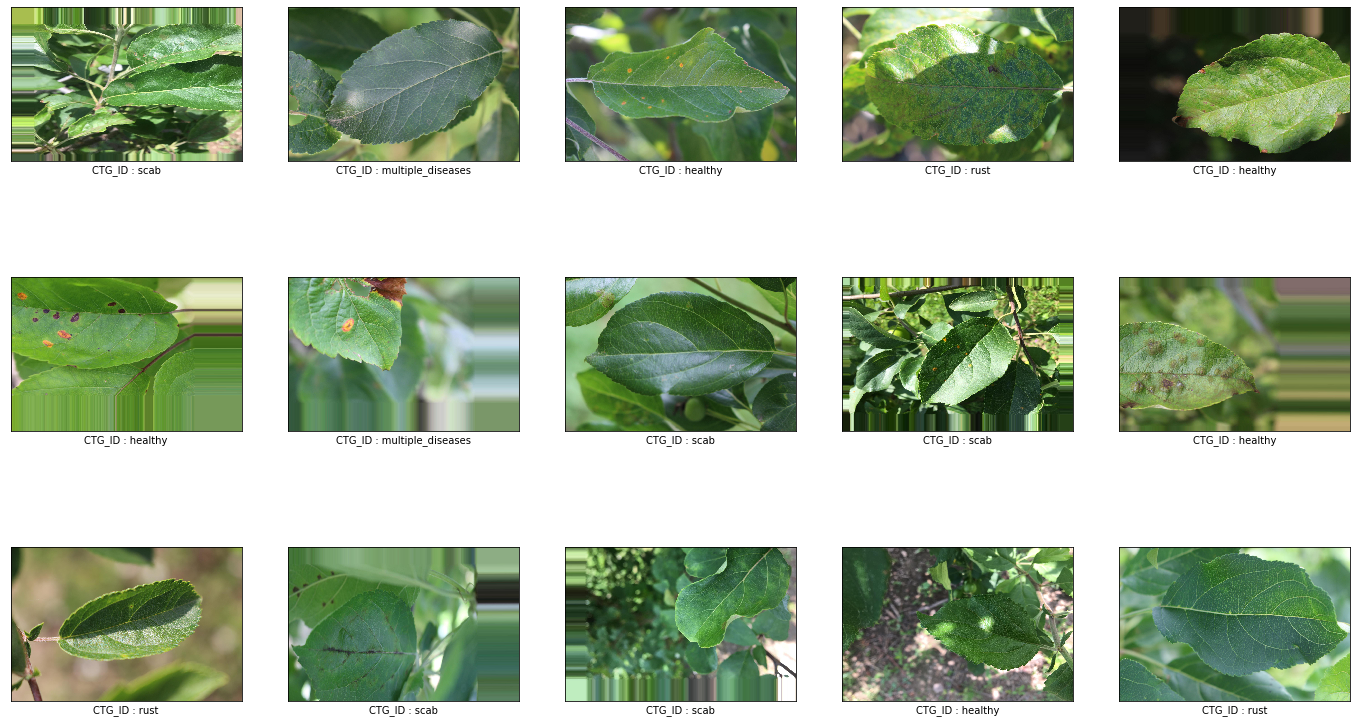

In [183]:
def plot_samples(df, size=(22,22), nb_samples=20, cmap=False):
    
    plt.figure(figsize=size)
    humnaize_labels = df.columns[1:]
    for i in range(nb_samples):
        random_sample = df.iloc[np.random.random_integers(i,len(df) - 1)]
        
        if cmap:
            random_sample_img = Image.open(path_image+random_sample['image_id']).convert("L")
        else:
            random_sample_img = mpimg.imread(path_image+random_sample['image_id'])
            
        arr = np.asarray(random_sample_img)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        if cmap:
            plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(random_sample_img, cmap=plt.cm.binary)
          
        plt.xlabel("CTG_ID : %s" % (humaines_labels(np.argmax(list(df.iloc[i][1:])))))
    plt.show()
    
plot_samples(df_samples, size=(24,24), nb_samples=15)

In [184]:
def hyperParams():
        
    modelParams = {"Layers":[{"neurons":512 , "activation":"relu","dropOut":False, "kernel_regularizer":False, "activity_regularizer":False},
                    {"neurons":255, "activation":"relu", "dropOut":0.1, "kernel_regularizer":False, "activity_regularizer":False},
                    {"neurons":128, "activation":"relu", "dropOut":0.2, "kernel_regularizer":False, "activity_regularizer":False},
                    {"neurons":4 , "activation":"softmax", "dropOut":False, "kernel_regularizer":False, "activity_regularizer":False}],
                   "loss":"categorical_crossentropy",
                   "optimizer":"Adam(lr=0.01)",
                   "metrics":"accuracy",
                   "learningRate":0.001,
                   "epochs":100,
                   "batchSize":250,
                   "testName":"MLP without drop out"
                 }
    return modelParams

params = hyperParams()

In [185]:
def create_model(params):
    
    model = Sequential()
    model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    for layers in params['Layers']:
        
        # ================ If kernel_regu & activity_regu == False ==============
        if (layers['kernel_regularizer'] == False) and (layers['activity_regularizer'] == False):
            model.add(Dense(layers['neurons'], activation=layers['activation']))
        # ============================== End False ==============================
        
        # ================ If kernel_regu & activity_regu True ==============
        elif (layers['kernel_regularizer'] == True) and (layers['activity_regularizer'] == True):
            model.add(Dense(layers['neurons'], activation=layers['activation'], kernel_regularizer=layers['kernel_regularizer'], activity_regularizer=layers['activity_regularizer']))
        
        # ================ If kernel_regu = True ==============
        elif (layers['kernel_regularizer'] == True) and (layers['activity_regularizer'] == False):
            model.add(Dense(layers['neurons'], activation=layers['activation'], kernel_regularizer=layers['kernel_regularizer']))
        
        # ================ If kernel_regu & activity_regu True ==============
        elif (layers['kernel_regularizer'] == False) and (layers['activity_regularizer'] == True):
            model.add(Dense(layers['neurons'], activation=layers['activation'], activity_regularizer=layers['activity_regularizer']))
            
        # ================ If dropout ==============
        if (layers['dropOut'] != False):
            model.add(Dropout(layers['dropOut']))

    opt = Adam(lr=params['learningRate'])
    model.compile(loss=params['loss'],
                   optimizer=opt,
                   metrics=['accuracy'])
    
    model.summary()
    return model

model = create_model(params)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               6291968   
_________________________________________________________________
dense_59 (Dense)             (None, 255)               130815    
_________________________________________________________________
dropout_14 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32768     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)               

In [186]:
def fitModel(model, params, trainImages, trainLabels, testImges, testLabels):
    
    start_time = time.time()
#     tensorboard = TensorBoard(log_dir='D:\logsProject\{}'.format(logName()))
    ################################ CALCULATE RUNTIME - START ###############################
    history = model.fit(trainImages, trainLabels,
                       epochs=params['epochs'],
                       batch_size=params['batchSize'], verbose=1, validation_data=(testImges, testLabels))
    ################################ CALCULATE RUNTIME - END ###############################
    print(humanize_time(time.time() - start_time))
    return model, history

In [187]:
model, history = fitModel(model, params, x_train, y_train, x_valid, y_valid)

Train on 3394 samples, validate on 849 samples
Epoch 1/100
3394/3394 [==============================] - 1s 374us/sample - loss: 4.1267 - accuracy: 0.2646 - val_loss: 1.5668 - val_accuracy: 0.2697
Epoch 2/100
3394/3394 [==============================] - 1s 253us/sample - loss: 1.7235 - accuracy: 0.2593 - val_loss: 1.3909 - val_accuracy: 0.2544
Epoch 3/100
3394/3394 [==============================] - 1s 256us/sample - loss: 1.4533 - accuracy: 0.2584 - val_loss: 1.3732 - val_accuracy: 0.2933
Epoch 4/100
3394/3394 [==============================] - 1s 249us/sample - loss: 1.3942 - accuracy: 0.2775 - val_loss: 1.3770 - val_accuracy: 0.3086
Epoch 5/100
3394/3394 [==============================] - 1s 251us/sample - loss: 1.3857 - accuracy: 0.2666 - val_loss: 1.3763 - val_accuracy: 0.2709
Epoch 6/100
3394/3394 [==============================] - 1s 246us/sample - loss: 1.3741 - accuracy: 0.3029 - val_loss: 1.3660 - val_accuracy: 0.3157
Epoch 7/100
3394/3394 [==============================] - 1s

In [188]:
def evaluateModel(model, testImages, testLabels):
    
    return model.evaluate(testImages, testLabels, batch_size=50, verbose=2)

evaluateModel(model, x_valid, y_valid)

849/1 - 0s - loss: 2.3081 - accuracy: 0.4441


[2.3168068847611316, 0.44405183]

In [189]:
def predictionPercent(model, testImages, testLabels):
    
    prediction = model.predict(testImages)
    predicted = []
    for i in range(len(prediction)):
        if np.argmax(testLabels[i]) == np.argmax(prediction[i]):
            predicted.append(1)
        else:
            predicted.append(0)
    print("Predicted percent {} %".format((sum(predicted)/(len(predicted)) * 100)))
    result = (sum(predicted)/len(predicted)) * 100
    
    return prediction, result

prd, result = predictionPercent(model, x_valid, y_valid)

Predicted percent 44.40518256772673 %


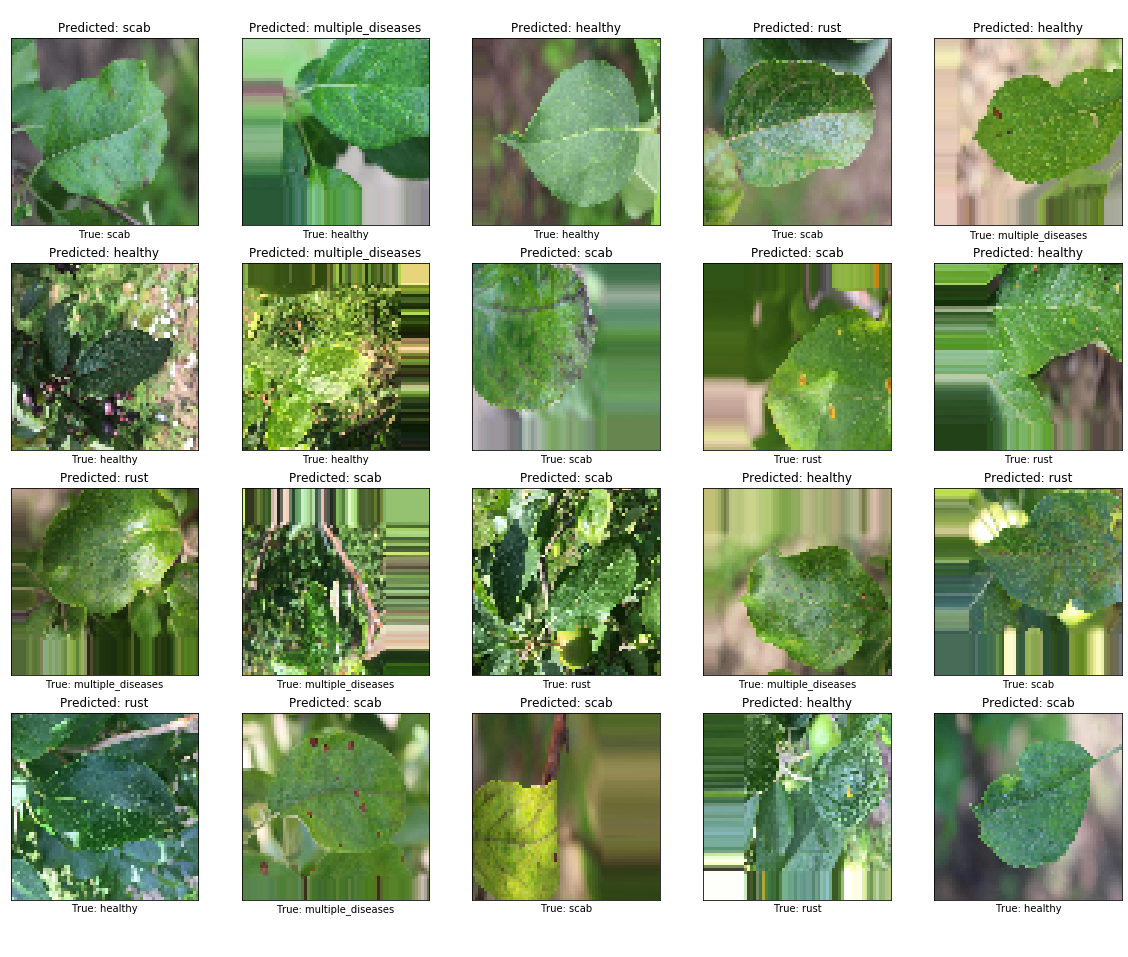

In [146]:
def plotPredictedResult(prediction, df,  testImages, testLabels):
    
    humnaize_labels = df.columns[1:]
    plt.figure(figsize=(20, 20))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(testImages[i])
        plt.xlabel("True: "+humnaize_labels[(np.argmax(testLabels[i]))]+"\n\n\n")
        plt.title("\nPredicted: "+humnaize_labels[np.argmax(list(df.iloc[i][1:]))])
        
    plt.show()

plotPredictedResult(prd, df_samples, x_valid, y_valid)

In [147]:
def trace(x,y,imagesLabels,color):
        trace = go.Scatter(
            x = x,y = y,
            name=imagesLabels,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plotAccLoss(model):
    
    hist = model.history
    acc = hist['accuracy']
    valAcc = hist['val_accuracy']
    loss = hist['loss']
    valLoss = hist['val_loss']

    epochs = list(range(1,len(acc)+1))

    traceA = trace(epochs,acc,"Training accuracy", "Green")
    traceVa = trace(epochs,valAcc,"Validation accuracy", "Red")
    traceL = trace(epochs,loss,"Training loss", "Blue")
    traceVl = trace(epochs,valLoss,"Validation loss", "Magenta")

    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(traceA,1,1)
    fig.append_trace(traceVa,1,1)
    fig.append_trace(traceL,1,2)
    fig.append_trace(traceVl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])


    iplot(fig, filename='accuracy-loss')

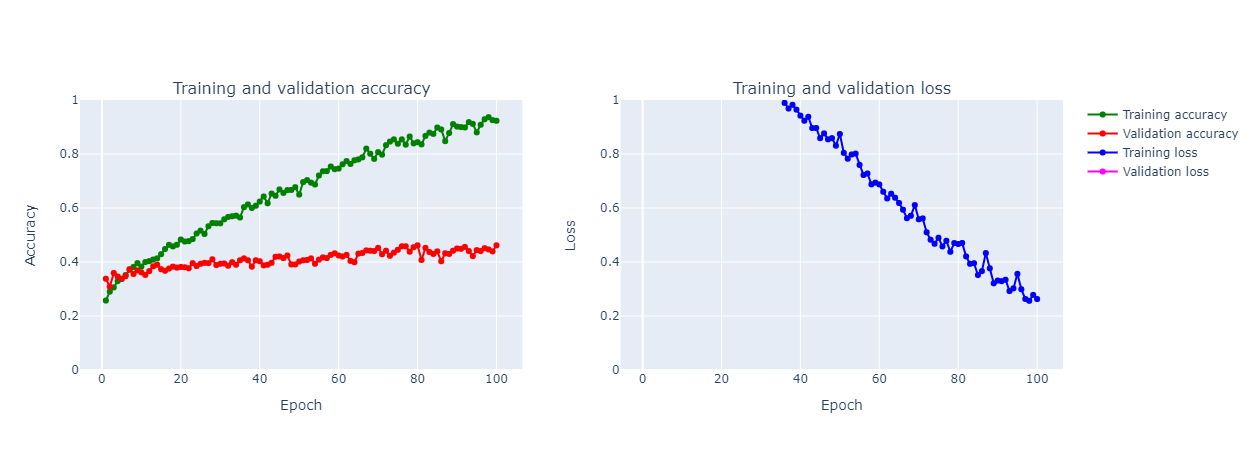

In [148]:
plotAccLoss(history)

In [157]:
ID = np.random.random_integers(1000, 999999)
def save_model(model, ID, result):
    
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    today = str(date.today()).split('-')
    today = today[2]+"_"+today[1]+"_"+today[0]
    runTime = ("%s_%s" %(today,current_time))
    model.save('D:\PlantPato\Models\mlp\model_run_'+runTime+"_"+str(ID)+"_["+str(round(result, 2))+"]")

save_model(model, ID, result)

INFO:tensorflow:Assets written to: D:\PlantPato\Models\mlp\model_run_10_05_2020_23-40-04_341582_[46.17]\assets


<h1 style="color:#987753"><center>============= MAKE A PREDECTION =============</center></h1>

In [159]:
df_samples_test = pd.read_csv(path+"test.csv")
copy_df_samples = pd.read_csv(path+"test.csv")
df_samples_test['image_id'] = pd.Series([img+'.jpg' for img in df_samples_test.image_id if '.jpg' not in img])

In [161]:
# df_samples_test.head(4)
copy_df_samples.sample(4)

image_id
385    Test_385
1501  Test_1501
1623  Test_1623
662    Test_662

In [164]:
x_test = load_data(df_samples_test, resize_to=(64,64), train=False)

| |     #                                          | 1820 Elapsed Time: 0:00:58


In [166]:
predictions = model.predict(x_test, verbose=2)

1821/1 - 0s


In [167]:
dict_submit = {'image_id':list(copy_df_samples.image_id), 'healthy':list(predictions[:,0]), 'multiple_diseases':list(predictions[:,1]), 'rust':list(predictions[:,2]), 'scab':list(predictions[:,3])}
sample_submission_df = pd.DataFrame(dict_submit)

In [168]:
sample_submission_df.head(4)

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.146424           0.039055  0.231122  0.583400
1   Test_1  0.061706           0.322765  0.434767  0.180762
2   Test_2  0.514575           0.384111  0.024291  0.077023
3   Test_3  0.658810           0.015509  0.054880  0.270800

In [171]:
sample_submission_df.to_csv('../../output/submission/sample_submission_MLP_'+str(ID)+'_['+str(round(result, 2))+'].csv', sep=',', index=False)